In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [6]:
df = pd.read_csv("processed_dataset.csv")

feature_columns = ["url_len", "num_unsafe_chars", "num_digits", "num_subdomains",
                   "is_ip", "num_params", "num_slashes", "contains_suspicious_keywords",
                   "contains_suspicious_file_extension", "short_url", "url_entropy", "has_https", "tfidf_score"]

X = df[feature_columns]
y = df["type"] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

**Logistc Regression**

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [7]:
model = make_pipeline(StandardScaler(), 
                      LogisticRegression(solver='saga', max_iter=3000, class_weight='balanced' ,random_state=10))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("LogisticRegression Model Accuracy: ", accuracy_score(y_test, y_pred))
print("classification_report: \n", classification_report(y_test, y_pred))

LogisticRegression Model Accuracy:  0.8155851933752563
classification_report: 
               precision    recall  f1-score   support

      benign       0.92      0.87      0.89     85829
  defacement       0.80      0.89      0.84     19299
     malware       0.61      0.78      0.68      6383
    phishing       0.50      0.52      0.51     18728

    accuracy                           0.82    130239
   macro avg       0.70      0.77      0.73    130239
weighted avg       0.83      0.82      0.82    130239



In [11]:
#test for overfitting
y_train_pred = model.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("classification_report: \n", classification_report(y_train, y_train_pred))

Training Accuracy:  0.8124299359633901
classification_report: 
               precision    recall  f1-score   support

      benign       0.92      0.86      0.89    342918
  defacement       0.80      0.89      0.84     77158
     malware       0.60      0.79      0.68     26137
    phishing       0.49      0.52      0.50     74739

    accuracy                           0.81    520952
   macro avg       0.70      0.76      0.73    520952
weighted avg       0.82      0.81      0.82    520952



In [12]:
joblib.dump(model, "models\Logistic_model.pkl")
print("Model saved.")

Model saved.


Note: Performance of logistic regression is impacted due to the presence of outliers and class imbalance. We can shift to trees to overcome this.

**Random Forest Classifier**

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
model_forest = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=10)
model_forest.fit(X_train, y_train)

y_pred_forest = model_forest.predict(X_test)

print("RandomForestClassifier Model Accuracy: ", accuracy_score(y_test, y_pred_forest))
print("classification_report: \n", classification_report(y_test, y_pred_forest))

RandomForestClassifier Model Accuracy:  0.9590368476416434
classification_report: 
               precision    recall  f1-score   support

      benign       0.97      0.99      0.98     85829
  defacement       0.96      0.98      0.97     19299
     malware       0.98      0.94      0.96      6383
    phishing       0.91      0.81      0.86     18728

    accuracy                           0.96    130239
   macro avg       0.96      0.93      0.94    130239
weighted avg       0.96      0.96      0.96    130239



In [ ]:
#test for overfitting
y_train_pred = model_forest.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred))
print("classification_report: \n", classification_report(y_train, y_train_pred))

Training Accuracy:  0.995546614659316
classification_report: 
               precision    recall  f1-score   support

      benign       1.00      1.00      1.00    342918
  defacement       1.00      1.00      1.00     77158
     malware       1.00      0.98      0.99     26137
    phishing       0.98      0.99      0.98     74739

    accuracy                           1.00    520952
   macro avg       0.99      0.99      0.99    520952
weighted avg       1.00      1.00      1.00    520952



Note: Random Forest model seems to overfit

In [16]:
joblib.dump(model_forest, "models\Random_forest_model.pkl")
print("Model saved.")

Model saved.


**LightGBM Classifier**

In [17]:
from lightgbm import LGBMClassifier, early_stopping

In [18]:
model_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=4,
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=10,
    reg_alpha=0.5,
    reg_lambda=0.5,
    is_unbalance=True,
    random_state=10
)

model_lgbm.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          callbacks=[early_stopping(stopping_rounds=50)],
          eval_metric='multi_logloss'
          )

y_pred_lgbm = model_lgbm.predict(X_test,  num_iteration=model_lgbm.best_iteration_)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019854 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 520952, number of used features: 13
[LightGBM] [Info] Start training from score -0.418167
[LightGBM] [Info] Start training from score -1.909803
[LightGBM] [Info] Start training from score -2.992306
[LightGBM] [Info] Start training from score -1.941656
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mult

In [39]:
print("LGBMClassifier Model Accuracy: ", accuracy_score(y_test, y_pred_lgbm)) 
print("classification_report: \n", classification_report(y_test, y_pred_lgbm))

LGBMClassifier Model Accuracy:  0.9566566082356284
classification_report: 
               precision    recall  f1-score   support

      benign       0.96      0.99      0.98     85829
  defacement       0.96      0.98      0.97     19299
     malware       0.98      0.92      0.95      6383
    phishing       0.93      0.79      0.85     18728

    accuracy                           0.96    130239
   macro avg       0.96      0.92      0.94    130239
weighted avg       0.96      0.96      0.96    130239



In [19]:
#test for overfitting
y_train_pred_lgbm = model_lgbm.predict(X_train)
print("Training Accuracy: ", accuracy_score(y_train, y_train_pred_lgbm))
print("classification_report: \n", classification_report(y_train, y_train_pred_lgbm))

Training Accuracy:  0.9622134092968259
classification_report: 
               precision    recall  f1-score   support

      benign       0.96      0.99      0.98    342918
  defacement       0.96      0.99      0.98     77158
     malware       0.99      0.93      0.96     26137
    phishing       0.94      0.80      0.87     74739

    accuracy                           0.96    520952
   macro avg       0.97      0.93      0.95    520952
weighted avg       0.96      0.96      0.96    520952



In [21]:
joblib.dump(model_lgbm, "models\LightGBM_model.pkl")
print("Model saved.")

Model saved.


Note: Random Forest and LightGBM classifier both result in about 95 percent accuracy. However, LightGBM doesn't overfit, therefore it is preferred.

**Confusion Matrix for LightGBM**

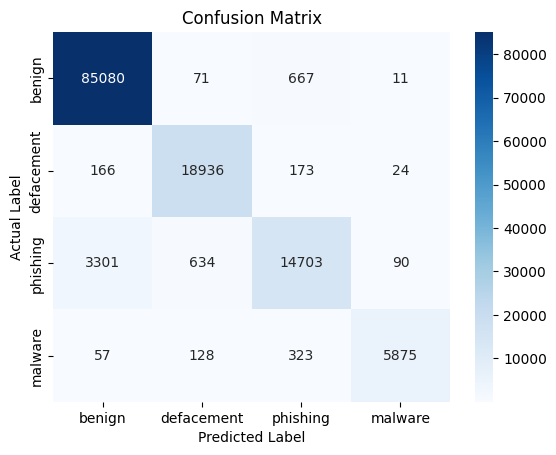

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = ["benign", "defacement", "phishing", "malware"]
cm = confusion_matrix(y_test, y_pred_lgbm, labels=labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()